In [25]:
# ======================================
# Complete Preprocessing + Train/Test Handling (Combined Snippet)
# ======================================

import os
import librosa
import numpy as np
import pandas as pd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# -----------------------------
# 1️⃣ Load Data
# -----------------------------
train_csv = "/kaggle/input/airs-ai-in-respiratory-sounds/train.csv"
test_csv  = "/kaggle/input/airs-ai-in-respiratory-sounds/test.csv"
audio_path = "/kaggle/input/airs-ai-in-respiratory-sounds/sounds/sounds"

train_df = pd.read_csv(train_csv)
test_df  = pd.read_csv(test_csv)

tab_features = ['age', 'gender', 'tbContactHistory', 'wheezingHistory', 'phlegmCough',
                'familyAsthmaHistory', 'feverHistory', 'coldPresent', 'packYears']

# -----------------------------
# 2️⃣ Map audio files
# -----------------------------
file_map = {}
for folder in os.listdir(audio_path):
    fpath = os.path.join(audio_path, folder)
    if os.path.isdir(fpath):
        wavs = [f for f in os.listdir(fpath) if f.endswith(".wav")]
        if wavs:
            file_map[folder] = os.path.join(fpath, wavs[0])

# -----------------------------
# 3️⃣ MFCC Extraction Function
# -----------------------------
def extract_mfcc_features(file_path, n_mfcc=40, duration=5, sr=22050):
    try:
        y, sr = librosa.load(file_path, sr=sr, duration=duration)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        mfcc_scaled = np.mean(mfcc.T, axis=0)
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        chroma_scaled = np.mean(chroma.T, axis=0)
        mel = librosa.feature.melspectrogram(y=y, sr=sr)
        mel_scaled = np.mean(mel.T, axis=0)
        features = np.hstack([mfcc_scaled, chroma_scaled, mel_scaled])
        return features
    except:
        return np.zeros(n_mfcc + 12 + 128)

# -----------------------------
# 4️⃣ Extract features for train
# -----------------------------
X_audio = []
valid_ids = []
for i, cid in enumerate(train_df['candidateID']):
    if cid in file_map:
        X_audio.append(extract_mfcc_features(file_map[cid]))
        valid_ids.append(cid)
X_audio = np.array(X_audio)

df = train_df[train_df['candidateID'].isin(valid_ids)]
X_tab = df[tab_features].values
y = df['disease'].values

# -----------------------------
# 5️⃣ Extract features for test
# -----------------------------
X_audio_test = []
for i, cid in enumerate(test_df['candidateID']):
    if cid in file_map:
        X_audio_test.append(extract_mfcc_features(file_map[cid]))
X_audio_test = np.array(X_audio_test)
X_tab_test = test_df[tab_features].values

# -----------------------------
# 6️⃣ Iterative Imputation + Scaling (Train + Test)
# -----------------------------
iterative_imputer = IterativeImputer(
    max_iter=10,
    random_state=42,
    estimator=RandomForestClassifier(n_estimators=50, random_state=42)
)
X_tab_iterative = iterative_imputer.fit_transform(X_tab)
X_tab_test_iterative = iterative_imputer.transform(X_tab_test)  # apply same imputer

scaler_tab = StandardScaler()
X_tab_scaled = scaler_tab.fit_transform(X_tab_iterative)
X_tab_scaled_test = scaler_tab.transform(X_tab_test_iterative)

# -----------------------------
# 7️⃣ Train-validation split
# -----------------------------
X_tab_train, X_tab_val, X_audio_train, X_audio_val, y_train, y_val = train_test_split(
    X_tab_scaled, X_audio, y,
    test_size=0.15,
    stratify=y,
    random_state=42
)

# Reshape audio for model
X_audio_train = X_audio_train.reshape(X_audio_train.shape[0], X_audio_train.shape[1], 1)
X_audio_val = X_audio_val.reshape(X_audio_val.shape[0], X_audio_val.shape[1], 1)
X_audio_test_fixed = X_audio_test.reshape(X_audio_test.shape[0], X_audio_test.shape[1], 1)

# -----------------------------
# 8️⃣ Class Weights
# -----------------------------
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

# -----------------------------
# 9️⃣ Flatten MFCC for augmentation (Train only)
# -----------------------------
X_mel_2d = X_audio_train.reshape(X_audio_train.shape[0], -1)
X_tab_mel = X_tab_train
y_mel = y_train

def advanced_flat_augmentation(feature_vector):
    augmented = feature_vector.copy()
    if np.random.random() > 0.5:
        augmented += np.random.normal(0, 0.01, augmented.shape)
    if np.random.random() > 0.5:
        augmented = np.roll(augmented, np.random.randint(-5,5))
    return augmented

X_mel_augmented = []
X_tab_augmented = []
y_augmented = []

# Original train data
X_mel_augmented.extend(X_mel_2d)
X_tab_augmented.extend(X_tab_mel)
y_augmented.extend(y_mel)

# Augmented data (3x)
for i in range(len(X_mel_2d)):
    for _ in range(3):
        aug_mel = advanced_flat_augmentation(X_mel_2d[i])
        X_mel_augmented.append(aug_mel)
        X_tab_augmented.append(X_tab_mel[i])
        y_augmented.append(y_mel[i])

X_mel_augmented = np.array(X_mel_augmented)
X_tab_augmented = np.array(X_tab_augmented)
y_augmented = np.array(y_augmented)

print("✅ Preprocessing complete! Ready for training + testing.")
print(f"Train samples (augmented): {len(X_mel_augmented)}, Test samples: {X_audio_test_fixed.shape[0]}")


/usr/local/lib/python3.11/dist-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/usr/local/lib/python3.11/dist-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


✅ Preprocessing complete! Ready for training + testing.
Train samples (augmented): 1856, Test samples: 338


In [26]:
# -----------------------------
# 7️⃣ Train-validation split (85% train, 15% validation)
# -----------------------------
X_tab_train, X_tab_val, X_audio_train, X_audio_val, y_train, y_val = train_test_split(
    X_tab_scaled, X_audio, y,
    test_size=0.15,       # 15% for validation
    stratify=y,
    random_state=42
)

# Reshape audio for model
X_audio_train = X_audio_train.reshape(X_audio_train.shape[0], X_audio_train.shape[1], 1)
X_audio_val = X_audio_val.reshape(X_audio_val.shape[0], X_audio_val.shape[1], 1)
X_audio_test_fixed = X_audio_test.reshape(X_audio_test.shape[0], X_audio_test.shape[1], 1)

print(f"✅ Training samples: {X_audio_train.shape[0]}, Validation samples: {X_audio_val.shape[0]}, Test samples: {X_audio_test_fixed.shape[0]}")


✅ Training samples: 464, Validation samples: 82, Test samples: 338


✅ Flattened MFCC features: Train (1577, 180), Val (279, 180)
✅ Model created and compiled!


Model: "fixed_super_advanced_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ pretrained_features │ (None, 180)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 1024)      │    185,344 │ pretrained_featu… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1024)      │      4,096 │ dense_26[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tabular_input       │ (None, 9)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 1024)      │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_29 (Dense)    │ (None, 256)       │      2,560 │ tabular_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_27 (Dense)    │ (None, 512)       │    524,800 │ dropout_18[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_29[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_27[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_21          │ (None, 256)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (None, 512)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_30 (Dense)    │ (None, 128)       │     32,896 │ dropout_21[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_28 (Dense)    │ (None, 256)       │    131,328 │ dropout_19[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_30[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_28[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_22          │ (None, 128)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, 256)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_31 (Dense)    │ (None, 64)        │      8,256 │ dropout_22[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 320)       │          0 │ dropout_20[0][0]

 Total params: 1,566,019 (5.97 MB)

 Trainable params: 1,558,339 (5.94 MB)

 Non-trainable params: 7,680 (30.00 KB)

✅ Class weights: {0: 1.301155115511551, 1: 0.7651625424551188, 2: 1.0816186556927299}
Epoch 1/300
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.2825 - loss: 1.6869
Epoch 1: val_accuracy improved from -inf to 0.30466, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 20s 76ms/step - accuracy: 0.2826 - loss: 1.6858 - val_accuracy: 0.3047 - val_loss: 1.2430 - learning_rate: 1.0000e-04
Epoch 2/300
91/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3197 - loss: 1.3735
Epoch 2: val_accuracy did not improve from 0.30466
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3201 - loss: 1.3702 - val_accuracy: 0.2903 - val_loss: 1.2089 - learning_rate: 1.0000e-04
Epoch 3/300
88/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3337 - loss: 1.2603
Epoch 3: val_accuracy improved from 0.30466 to 0.32616, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3340 - loss: 1.2618 - val_accuracy: 0.3262 - val_loss: 1.1578 - learning_rate: 1.0000e-04
Epoch 4/300
91/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3633 - loss: 1.1953
Epoch 4: val_accuracy improved from 0.32616 to 0.44086, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3656 - loss: 1.1941 - val_accuracy: 0.4409 - val_loss: 1.0869 - learning_rate: 1.0000e-04
Epoch 5/300
89/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4201 - loss: 1.1494
Epoch 5: val_accuracy improved from 0.44086 to 0.51254, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4194 - loss: 1.1509 - val_accuracy: 0.5125 - val_loss: 1.0108 - learning_rate: 1.0000e-04
Epoch 6/300
91/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4327 - loss: 1.1188
Epoch 6: val_accuracy improved from 0.51254 to 0.53405, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4341 - loss: 1.1173 - val_accuracy: 0.5341 - val_loss: 0.9349 - learning_rate: 1.0000e-04
Epoch 7/300
89/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4505 - loss: 1.0627
Epoch 7: val_accuracy improved from 0.53405 to 0.63799, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4508 - loss: 1.0625 - val_accuracy: 0.6380 - val_loss: 0.8676 - learning_rate: 1.0000e-04
Epoch 8/300
91/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4943 - loss: 1.0358
Epoch 8: val_accuracy improved from 0.63799 to 0.68100, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4946 - loss: 1.0357 - val_accuracy: 0.6810 - val_loss: 0.8362 - learning_rate: 1.0000e-04
Epoch 9/300
91/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5143 - loss: 0.9638
Epoch 9: val_accuracy improved from 0.68100 to 0.73118, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5157 - loss: 0.9633 - val_accuracy: 0.7312 - val_loss: 0.8085 - learning_rate: 1.0000e-04
Epoch 10/300
89/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5313 - loss: 0.9898
Epoch 10: val_accuracy improved from 0.73118 to 0.74194, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5306 - loss: 0.9875 - val_accuracy: 0.7419 - val_loss: 0.7903 - learning_rate: 1.0000e-04
Epoch 11/300
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5942 - loss: 0.8860
Epoch 11: val_accuracy improved from 0.74194 to 0.75986, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5943 - loss: 0.8858 - val_accuracy: 0.7599 - val_loss: 0.7561 - learning_rate: 1.0000e-04
Epoch 12/300
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6018 - loss: 0.8646
Epoch 12: val_accuracy improved from 0.75986 to 0.76344, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6017 - loss: 0.8647 - val_accuracy: 0.7634 - val_loss: 0.7389 - learning_rate: 1.0000e-04
Epoch 13/300
97/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6534 - loss: 0.8017
Epoch 13: val_accuracy improved from 0.76344 to 0.79570, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6530 - loss: 0.8021 - val_accuracy: 0.7957 - val_loss: 0.6948 - learning_rate: 1.0000e-04
Epoch 14/300
97/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6551 - loss: 0.8245
Epoch 14: val_accuracy did not improve from 0.79570
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6552 - loss: 0.8239 - val_accuracy: 0.7957 - val_loss: 0.6702 - learning_rate: 1.0000e-04
Epoch 15/300
91/99 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6535 - loss: 0.7791
Epoch 15: val_accuracy did not improve from 0.79570
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6543 - loss: 0.7780 - val_accuracy: 0.7885 - val_loss: 0.6519 - learning_rate: 1.0000e-04
Epoch 16/300
98/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6699 - loss: 0.7851
Epoch 16: val_accuracy improved from 0.79570 to 0.80287, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6704 - loss: 0.7842 - val_accuracy: 0.8029 - val_loss: 0.6290 - learning_rate: 1.0000e-04
Epoch 17/300
98/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7197 - loss: 0.7102
Epoch 17: val_accuracy did not improve from 0.80287
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7195 - loss: 0.7102 - val_accuracy: 0.7849 - val_loss: 0.6068 - learning_rate: 1.0000e-04
Epoch 18/300
88/99 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7391 - loss: 0.7198
Epoch 18: val_accuracy did not improve from 0.80287
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7378 - loss: 0.7193 - val_accuracy: 0.7957 - val_loss: 0.5886 - learning_rate: 1.0000e-04
Epoch 19/300
98/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7549 - loss: 0.6982
Epoch 19: val_accuracy did not improve from 0.80287
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7547 - loss: 0.6978 - val_accuracy: 0.7921 - val_loss: 0.5794 - learning_rate: 1.0000e-04
Epoch 20/300
9

99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7598 - loss: 0.6356 - val_accuracy: 0.8100 - val_loss: 0.5314 - learning_rate: 1.0000e-04
Epoch 27/300
97/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7498 - loss: 0.6244
Epoch 27: val_accuracy improved from 0.81004 to 0.81720, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7500 - loss: 0.6245 - val_accuracy: 0.8172 - val_loss: 0.5223 - learning_rate: 1.0000e-04
Epoch 28/300
98/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7634 - loss: 0.6208
Epoch 28: val_accuracy did not improve from 0.81720
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7636 - loss: 0.6206 - val_accuracy: 0.8065 - val_loss: 0.5215 - learning_rate: 1.0000e-04
Epoch 29/300
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7635 - loss: 0.6011
Epoch 29: val_accuracy did not improve from 0.81720
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7635 - loss: 0.6012 - val_accuracy: 0.8136 - val_loss: 0.5176 - learning_rate: 1.0000e-04
Epoch 30/300
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7659 - loss: 0.6506
Epoch 30: val_accuracy did not improve from 0.81720
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7660 - loss: 0.6503 - val_accuracy: 0.8100 - val_loss: 0.5109 - learning_rate: 1.0000e-04
Epoch 31/300
8

99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7935 - loss: 0.5565 - val_accuracy: 0.8208 - val_loss: 0.4881 - learning_rate: 1.0000e-04
Epoch 41/300
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8141 - loss: 0.5168
Epoch 41: val_accuracy did not improve from 0.82079
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8140 - loss: 0.5168 - val_accuracy: 0.8172 - val_loss: 0.4810 - learning_rate: 1.0000e-04
Epoch 42/300
96/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8052 - loss: 0.5225
Epoch 42: val_accuracy improved from 0.82079 to 0.83154, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8047 - loss: 0.5228 - val_accuracy: 0.8315 - val_loss: 0.4774 - learning_rate: 1.0000e-04
Epoch 43/300
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7869 - loss: 0.5485
Epoch 43: val_accuracy did not improve from 0.83154
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7869 - loss: 0.5484 - val_accuracy: 0.8244 - val_loss: 0.4762 - learning_rate: 1.0000e-04
Epoch 44/300
97/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8112 - loss: 0.4910
Epoch 44: val_accuracy did not improve from 0.83154
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8110 - loss: 0.4920 - val_accuracy: 0.8280 - val_loss: 0.4709 - learning_rate: 1.0000e-04
Epoch 45/300
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7797 - loss: 0.5380
Epoch 45: val_accuracy did not improve from 0.83154
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7797 - loss: 0.5379 - val_accuracy: 0.8136 - val_loss: 0.4792 - learning_rate: 1.0000e-04
Epoch 46/300
9

99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8124 - loss: 0.4937 - val_accuracy: 0.8351 - val_loss: 0.4487 - learning_rate: 1.0000e-04
Epoch 51/300
97/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8158 - loss: 0.4767
Epoch 51: val_accuracy did not improve from 0.83513
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8157 - loss: 0.4776 - val_accuracy: 0.8244 - val_loss: 0.4415 - learning_rate: 1.0000e-04
Epoch 52/300
98/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8141 - loss: 0.4652
Epoch 52: val_accuracy did not improve from 0.83513
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8140 - loss: 0.4659 - val_accuracy: 0.8136 - val_loss: 0.4407 - learning_rate: 1.0000e-04
Epoch 53/300
94/99 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8268 - loss: 0.4513
Epoch 53: val_accuracy did not improve from 0.83513
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8264 - loss: 0.4533 - val_accuracy: 0.8280 - val_loss: 0.4410 - learning_rate: 1.0000e-04
Epoch 54/300
8

99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8134 - loss: 0.4721 - val_accuracy: 0.8387 - val_loss: 0.4290 - learning_rate: 1.0000e-04
Epoch 59/300
88/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8167 - loss: 0.4897
Epoch 59: val_accuracy did not improve from 0.83871
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8167 - loss: 0.4902 - val_accuracy: 0.8315 - val_loss: 0.4276 - learning_rate: 1.0000e-04
Epoch 60/300
90/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7946 - loss: 0.5130
Epoch 60: val_accuracy did not improve from 0.83871
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7961 - loss: 0.5104 - val_accuracy: 0.8280 - val_loss: 0.4281 - learning_rate: 1.0000e-04
Epoch 61/300
90/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8303 - loss: 0.4366
Epoch 61: val_accuracy improved from 0.83871 to 0.84588, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8292 - loss: 0.4379 - val_accuracy: 0.8459 - val_loss: 0.4252 - learning_rate: 1.0000e-04
Epoch 62/300
90/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8165 - loss: 0.4571
Epoch 62: val_accuracy did not improve from 0.84588
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8171 - loss: 0.4577 - val_accuracy: 0.8351 - val_loss: 0.4226 - learning_rate: 1.0000e-04
Epoch 63/300
91/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8251 - loss: 0.4616
Epoch 63: val_accuracy did not improve from 0.84588
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8252 - loss: 0.4611 - val_accuracy: 0.8315 - val_loss: 0.4197 - learning_rate: 1.0000e-04
Epoch 64/300
91/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8358 - loss: 0.4140
Epoch 64: val_accuracy did not improve from 0.84588
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8350 - loss: 0.4173 - val_accuracy: 0.8315 - val_loss: 0.4187 - learning_rate: 1.0000e-04
Epoch 65/300
9

99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8144 - loss: 0.4408 - val_accuracy: 0.8530 - val_loss: 0.4004 - learning_rate: 1.0000e-04
Epoch 72/300
89/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8097 - loss: 0.4324
Epoch 72: val_accuracy improved from 0.85305 to 0.85663, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8111 - loss: 0.4321 - val_accuracy: 0.8566 - val_loss: 0.3928 - learning_rate: 1.0000e-04
Epoch 73/300
90/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8258 - loss: 0.4254
Epoch 73: val_accuracy did not improve from 0.85663
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8260 - loss: 0.4276 - val_accuracy: 0.8495 - val_loss: 0.3935 - learning_rate: 1.0000e-04
Epoch 74/300
91/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8222 - loss: 0.4488
Epoch 74: val_accuracy did not improve from 0.85663
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8228 - loss: 0.4483 - val_accuracy: 0.8530 - val_loss: 0.3892 - learning_rate: 1.0000e-04
Epoch 75/300
91/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8519 - loss: 0.3747
Epoch 75: val_accuracy did not improve from 0.85663
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8507 - loss: 0.3783 - val_accuracy: 0.8530 - val_loss: 0.3878 - learning_rate: 1.0000e-04
Epoch 76/300
9

99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8543 - loss: 0.3490 - val_accuracy: 0.8674 - val_loss: 0.3674 - learning_rate: 1.0000e-04
Epoch 84/300
88/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8441 - loss: 0.4197
Epoch 84: val_accuracy improved from 0.86738 to 0.87097, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8442 - loss: 0.4188 - val_accuracy: 0.8710 - val_loss: 0.3709 - learning_rate: 1.0000e-04
Epoch 85/300
90/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8534 - loss: 0.3734
Epoch 85: val_accuracy did not improve from 0.87097
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8544 - loss: 0.3725 - val_accuracy: 0.8674 - val_loss: 0.3609 - learning_rate: 1.0000e-04
Epoch 86/300
90/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8381 - loss: 0.4113
Epoch 86: val_accuracy did not improve from 0.87097
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8373 - loss: 0.4113 - val_accuracy: 0.8602 - val_loss: 0.3614 - learning_rate: 1.0000e-04
Epoch 87/300
89/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8484 - loss: 0.3943
Epoch 87: val_accuracy did not improve from 0.87097
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8483 - loss: 0.3936 - val_accuracy: 0.8602 - val_loss: 0.3627 - learning_rate: 1.0000e-04
Epoch 88/300
9

99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8609 - loss: 0.3737 - val_accuracy: 0.8746 - val_loss: 0.3599 - learning_rate: 1.0000e-04
Epoch 90/300
90/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8326 - loss: 0.3962
Epoch 90: val_accuracy did not improve from 0.87455
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8337 - loss: 0.3948 - val_accuracy: 0.8674 - val_loss: 0.3601 - learning_rate: 1.0000e-04
Epoch 91/300
90/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8454 - loss: 0.4021
Epoch 91: val_accuracy did not improve from 0.87455
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8453 - loss: 0.4011 - val_accuracy: 0.8710 - val_loss: 0.3578 - learning_rate: 1.0000e-04
Epoch 92/300
92/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8498 - loss: 0.3945
Epoch 92: val_accuracy did not improve from 0.87455
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8503 - loss: 0.3947 - val_accuracy: 0.8674 - val_loss: 0.3628 - learning_rate: 1.0000e-04
Epoch 93/300
9

99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8634 - loss: 0.3543 - val_accuracy: 0.8781 - val_loss: 0.3535 - learning_rate: 1.0000e-04
Epoch 95/300
91/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8517 - loss: 0.3693
Epoch 95: val_accuracy did not improve from 0.87814
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8520 - loss: 0.3702 - val_accuracy: 0.8638 - val_loss: 0.3607 - learning_rate: 1.0000e-04
Epoch 96/300
90/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8463 - loss: 0.3941
Epoch 96: val_accuracy did not improve from 0.87814
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8477 - loss: 0.3905 - val_accuracy: 0.8674 - val_loss: 0.3479 - learning_rate: 1.0000e-04
Epoch 97/300
90/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8668 - loss: 0.3450
Epoch 97: val_accuracy did not improve from 0.87814
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8662 - loss: 0.3459 - val_accuracy: 0.8710 - val_loss: 0.3518 - learning_rate: 1.0000e-04
Epoch 98/300
9

99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8763 - loss: 0.2996 - val_accuracy: 0.8817 - val_loss: 0.3396 - learning_rate: 1.0000e-04
Epoch 103/300
91/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8632 - loss: 0.3360
Epoch 103: val_accuracy did not improve from 0.88172
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8622 - loss: 0.3379 - val_accuracy: 0.8710 - val_loss: 0.3434 - learning_rate: 1.0000e-04
Epoch 104/300
91/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8732 - loss: 0.3463
Epoch 104: val_accuracy did not improve from 0.88172
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8736 - loss: 0.3456 - val_accuracy: 0.8674 - val_loss: 0.3522 - learning_rate: 1.0000e-04
Epoch 105/300
89/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8668 - loss: 0.3567
Epoch 105: val_accuracy did not improve from 0.88172
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8669 - loss: 0.3551 - val_accuracy: 0.8710 - val_loss: 0.3483 - learning_rate: 1.0000e-04
Epoch 10

99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8693 - loss: 0.3275 - val_accuracy: 0.8925 - val_loss: 0.3216 - learning_rate: 1.0000e-04
Epoch 119/300
90/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8956 - loss: 0.2699
Epoch 119: val_accuracy did not improve from 0.89247
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8952 - loss: 0.2711 - val_accuracy: 0.8889 - val_loss: 0.3188 - learning_rate: 1.0000e-04
Epoch 120/300
91/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8876 - loss: 0.3245
Epoch 120: val_accuracy did not improve from 0.89247
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8866 - loss: 0.3247 - val_accuracy: 0.8889 - val_loss: 0.3145 - learning_rate: 1.0000e-04
Epoch 121/300
88/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8713 - loss: 0.2902
Epoch 121: val_accuracy did not improve from 0.89247
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8718 - loss: 0.2923 - val_accuracy: 0.8817 - val_loss: 0.3220 - learning_rate: 1.0000e-04
Epoch 12

99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8707 - loss: 0.3181 - val_accuracy: 0.8961 - val_loss: 0.3150 - learning_rate: 1.0000e-04
Epoch 125/300
90/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8929 - loss: 0.2921
Epoch 125: val_accuracy did not improve from 0.89606
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8936 - loss: 0.2915 - val_accuracy: 0.8853 - val_loss: 0.3127 - learning_rate: 1.0000e-04
Epoch 126/300
88/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8895 - loss: 0.2689
Epoch 126: val_accuracy improved from 0.89606 to 0.89964, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8904 - loss: 0.2678 - val_accuracy: 0.8996 - val_loss: 0.3139 - learning_rate: 1.0000e-04
Epoch 127/300
89/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9012 - loss: 0.2678
Epoch 127: val_accuracy did not improve from 0.89964
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8998 - loss: 0.2706 - val_accuracy: 0.8817 - val_loss: 0.3254 - learning_rate: 1.0000e-04
Epoch 128/300
87/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8886 - loss: 0.2711
Epoch 128: val_accuracy did not improve from 0.89964
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8885 - loss: 0.2712 - val_accuracy: 0.8925 - val_loss: 0.3224 - learning_rate: 1.0000e-04
Epoch 129/300
88/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8734 - loss: 0.3080
Epoch 129: val_accuracy did not improve from 0.89964
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8742 - loss: 0.3052 - val_accuracy: 0.8889 - val_loss: 0.3178 - learning_rate: 1.0000e-04
Epoch 13

99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8844 - loss: 0.2943 - val_accuracy: 0.9032 - val_loss: 0.3070 - learning_rate: 1.0000e-04
Epoch 135/300
91/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8700 - loss: 0.3355
Epoch 135: val_accuracy did not improve from 0.90323
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8700 - loss: 0.3343 - val_accuracy: 0.8961 - val_loss: 0.3084 - learning_rate: 1.0000e-04
Epoch 136/300
91/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8916 - loss: 0.2803
Epoch 136: val_accuracy did not improve from 0.90323
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8926 - loss: 0.2768 - val_accuracy: 0.8889 - val_loss: 0.3124 - learning_rate: 1.0000e-04
Epoch 137/300
91/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8782 - loss: 0.2997
Epoch 137: val_accuracy did not improve from 0.90323
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8792 - loss: 0.2965 - val_accuracy: 0.8996 - val_loss: 0.3197 - learning_rate: 1.0000e-04
Epoch 13

99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9039 - loss: 0.2515 - val_accuracy: 0.9068 - val_loss: 0.2823 - learning_rate: 5.0000e-05
Epoch 165/300
90/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8957 - loss: 0.2529
Epoch 165: val_accuracy did not improve from 0.90681
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8968 - loss: 0.2515 - val_accuracy: 0.8996 - val_loss: 0.2833 - learning_rate: 5.0000e-05
Epoch 166/300
90/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9055 - loss: 0.2277
Epoch 166: val_accuracy did not improve from 0.90681
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9063 - loss: 0.2259 - val_accuracy: 0.8925 - val_loss: 0.2867 - learning_rate: 5.0000e-05
Epoch 167/300
88/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9183 - loss: 0.1995
Epoch 167: val_accuracy did not improve from 0.90681
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9173 - loss: 0.2032 - val_accuracy: 0.8996 - val_loss: 0.2851 - learning_rate: 5.0000e-05
Epoch 16

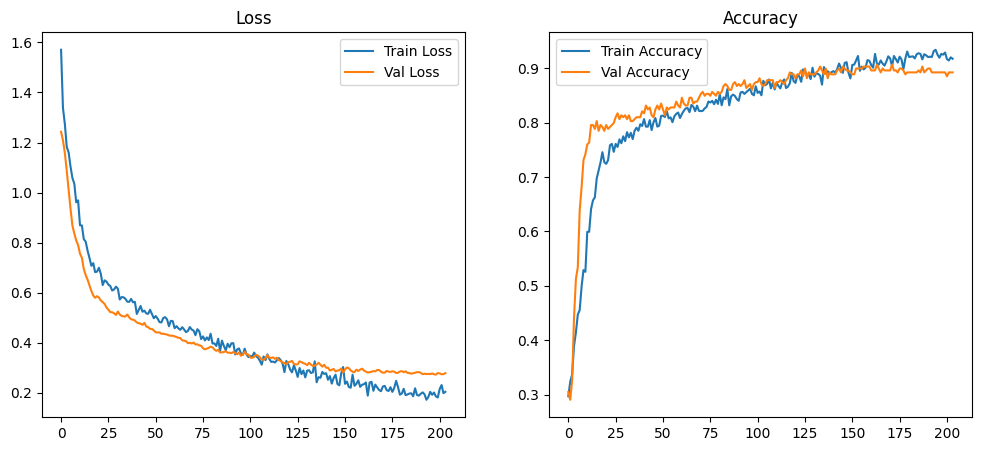

In [27]:
# ======================================
# FIXED SUPER ADVANCED MODEL TRAINING (No PCA)
# ======================================

import tensorflow as tf
from tensorflow.keras import layers, Model
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# 1️⃣ Convert augmented lists to arrays
# -----------------------------
X_mel_augmented = np.array(X_mel_augmented)
X_tab_augmented = np.array(X_tab_augmented)
y_augmented = np.array(y_augmented)

# -----------------------------
# 2️⃣ Train-validation split (85% train, 15% validation)
# -----------------------------
X_mel_aug_train, X_mel_aug_val, X_tab_aug_train, X_tab_aug_val, y_aug_train, y_aug_val = train_test_split(
    X_mel_augmented, X_tab_augmented, y_augmented,
    test_size=0.15,
    stratify=y_augmented,
    random_state=42
)

# -----------------------------
# 3️⃣ Flatten MFCC features
# -----------------------------
X_mel_aug_train_flat = X_mel_aug_train.reshape(X_mel_aug_train.shape[0], -1)
X_mel_aug_val_flat   = X_mel_aug_val.reshape(X_mel_aug_val.shape[0], -1)

print(f"✅ Flattened MFCC features: Train {X_mel_aug_train_flat.shape}, Val {X_mel_aug_val_flat.shape}")

# -----------------------------
# 4️⃣ Create Fixed Super Advanced Model
# -----------------------------
num_classes = 3

def create_fixed_super_advanced_model(tabular_dim, pretrained_dim, num_classes):
    """Fixed super advanced model"""
    
    pretrained_input = tf.keras.Input(shape=(pretrained_dim,), name='pretrained_features')
    x_pre = layers.Dense(1024, activation='relu')(pretrained_input)
    x_pre = layers.BatchNormalization()(x_pre)
    x_pre = layers.Dropout(0.4)(x_pre)
    x_pre = layers.Dense(512, activation='relu')(x_pre)
    x_pre = layers.BatchNormalization()(x_pre)
    x_pre = layers.Dropout(0.3)(x_pre)
    x_pre = layers.Dense(256, activation='relu')(x_pre)
    x_pre = layers.BatchNormalization()(x_pre)
    x_pre = layers.Dropout(0.2)(x_pre)
    
    tabular_input = tf.keras.Input(shape=(tabular_dim,), name='tabular_input')
    x_tab = layers.Dense(256, activation='relu')(tabular_input)
    x_tab = layers.BatchNormalization()(x_tab)
    x_tab = layers.Dropout(0.3)(x_tab)
    x_tab = layers.Dense(128, activation='relu')(x_tab)
    x_tab = layers.BatchNormalization()(x_tab)
    x_tab = layers.Dropout(0.2)(x_tab)
    x_tab = layers.Dense(64, activation='relu')(x_tab)
    
    combined = layers.concatenate([x_pre, x_tab])
    x = layers.Dense(512, activation='relu')(combined)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    
    residual1 = layers.Dense(512, activation='relu')(x)
    residual1 = layers.BatchNormalization()(residual1)
    x = layers.add([x, residual1])
    x = layers.Dropout(0.4)(x)
    
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    residual2 = layers.Dense(256, activation='relu')(x)
    residual2 = layers.BatchNormalization()(residual2)
    x = layers.add([x, residual2])
    x = layers.Dropout(0.3)(x)
    
    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(64, activation='relu')(x)
    
    output = layers.Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=[tabular_input, pretrained_input], outputs=output, name='fixed_super_advanced_model')
    return model

super_model = create_fixed_super_advanced_model(
    tabular_dim=X_tab_aug_train.shape[1],
    pretrained_dim=X_mel_aug_train_flat.shape[1],
    num_classes=num_classes
)

super_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("✅ Model created and compiled!")
super_model.summary()

# -----------------------------
# 5️⃣ Compute class weights
# -----------------------------
class_weights = compute_class_weight('balanced', classes=np.unique(y_aug_train), y=y_aug_train)
class_weight_dict = dict(enumerate(class_weights))
print(f"✅ Class weights: {class_weight_dict}")

# -----------------------------
# 6️⃣ Callbacks
# -----------------------------
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=40, restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=20, min_lr=1e-8, verbose=1),
    tf.keras.callbacks.ModelCheckpoint('fixed_super_advanced_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
]

# -----------------------------
# 7️⃣ Train the model
# -----------------------------
super_history = super_model.fit(
    [X_tab_aug_train, X_mel_aug_train_flat],
    y_aug_train,
    batch_size=16,
    epochs=300,
    validation_data=([X_tab_aug_val, X_mel_aug_val_flat], y_aug_val),
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=1
)

# -----------------------------
# 8️⃣ Evaluate on validation
# -----------------------------
from sklearn.metrics import accuracy_score

super_model.load_weights('fixed_super_advanced_model.h5')
super_pred = super_model.predict([X_tab_aug_val, X_mel_aug_val_flat])
super_accuracy = accuracy_score(y_aug_val, np.argmax(super_pred, axis=1))
print(f"\n🎯 Validation Accuracy: {super_accuracy:.4f}")

# -----------------------------
# 9️⃣ Plot train / validation metrics
# -----------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(super_history.history['loss'], label='Train Loss')
plt.plot(super_history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(super_history.history['accuracy'], label='Train Accuracy')
plt.plot(super_history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()


In [28]:
# ======================================
# Prepare test tabular features
# ======================================

# 1️⃣ Select tabular features from test_df
tab_features = ['age', 'gender', 'tbContactHistory', 'wheezingHistory', 
                'phlegmCough', 'familyAsthmaHistory', 'feverHistory', 
                'coldPresent', 'packYears']

X_tab_test = test_df[tab_features].values

# 2️⃣ Apply the same Iterative Imputer as training
X_tab_test_imputed = iterative_imputer.transform(X_tab_test)

# 3️⃣ Apply the same StandardScaler as training
X_tab_test_scaled = scaler_tab.transform(X_tab_test_imputed)

# 4️⃣ Reshape test audio features
X_audio_test_fixed = np.array(X_audio_test)  # Ensure it's np.array
X_audio_test_flat = X_audio_test_fixed.reshape(X_audio_test_fixed.shape[0], -1)

# 5️⃣ Predict
super_pred_test = super_model.predict([X_tab_test_scaled, X_audio_test_flat], verbose=1)
y_pred_test = np.argmax(super_pred_test, axis=1)

# 6️⃣ Display results
test_results_df = pd.DataFrame({
    'candidateID': test_df['candidateID'],
    'predicted_disease': y_pred_test
})

print("🎯 Sample predictions on test data:")
print(test_results_df.head(10))


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
🎯 Sample predictions on test data:
     candidateID  predicted_disease
0  136bac9a3e081                  0
1  b121e45942a46                  1
2  6b6853c07e4fb                  2
3  71de185eac888                  2
4  25deed742f133                  1
5  1de4591779d31                  0
6  102efeabb10a5                  1
7  522d1f8600a13                  2
8  e41530046a74e                  1
9  6337b96a160eb                  2
